# Train CNN on ABG data after pretraining on Xeno-Canto
- Uses local PC env ABG-cnn for resnet
- Uses local PC env ABG-cnn_tf230 for mobnet

In [1]:
import tensorflow as tf

#%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES=1

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.4.1'

In [2]:
# MODEL OUTPUT PATH
# Let's checkpoint the model here when needed
checkpoint_path = "C:/Users/tonys/Desktop/results/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
print("does this checkpoint exist?")
os.path.isfile(checkpoint_dir)

does this checkpoint exist?


False

In [3]:
# INPUT DATA
# Set up training data 
tr_pth = 'C:/Users/tonys/Documents/SchoolWork/Koret/data/training' # data with ABG classes
data_dir = pathlib.Path(tr_pth)

# Set up the validation data
val_pth = 'C:/Users/tonys/Documents/SchoolWork/Koret/data/validation'
val_data_dir = pathlib.Path(val_pth)

In [4]:
# PRETRAINED MODEL INPUT
# older (Aug 2020) ResNet ~44M params
#new_model = tf.keras.models.load_model('../data/pretrained_models/saved_model_6/my_model') 

# MobNet (Sep 2020) ~4.5M params
new_model = tf.keras.models.load_model('../data/pretrained_models/mobnetv2_saved_model_xc2/my_model')

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Functi (None, 7, 7, 1792)        4363712   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 45)                80685     
Total params: 4,444,397
Trainable params: 4,396,461
Non-trainable params: 47,936
_________________________________________________________________


### Functions

In [5]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [6]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000, repeat=1):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
        ds = ds.cache(cache)
    else:
        ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat(repeat)     # repeat has arg 'count' = A tf.int64 scalar tf.Tensor, representing the number of times the dataset should be repeated. The default behavior (if count is None or -1) is for the dataset be repeated indefinitely.

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

### Image analysis

In [7]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

7041

In [8]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

CLASS_NAMES

array(['anthro', 'bio', 'geo', 'other'], dtype='<U6')

In [9]:
# demo display mfccs
x = "test1"
wavi = list(data_dir.glob(x + '/*'))

for image_path in wavi[:3]:
    display.display(Image.open(str(image_path)))

In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [11]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\training\\bio\\3141_BIN_55.png'
b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\training\\anthro\\2052_AVT_124.png'
b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\training\\bio\\430_BAM_14.png'
b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\training\\bio\\1203_BBI_1372.png'
b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\training\\anthro\\2118_AVT_52.png'


In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False]


In [15]:
train_ds = prepare_for_training(labeled_ds, repeat = None)
image_batch, label_batch = next(iter(train_ds))

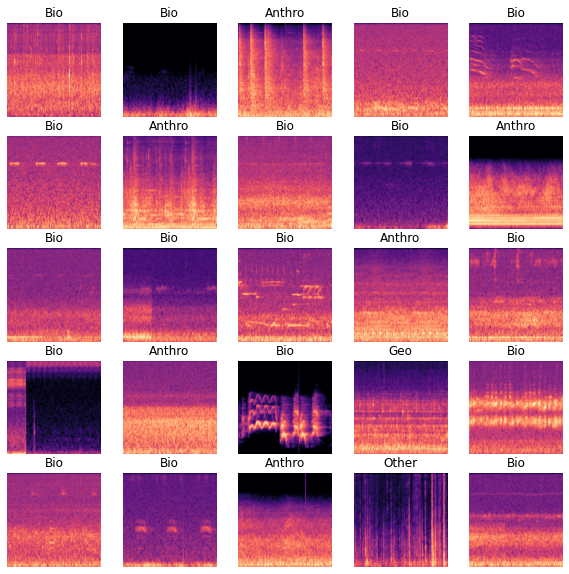

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
tr_pth

'C:/Users/tonys/Documents/SchoolWork/Koret/data/training'

#### Validation data

In [18]:
val_image_count = len(list(val_data_dir.glob('*/*.png')))
val_image_count

650

In [19]:
CLASS_NAMES = np.array([item.name for item in val_data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['anthro', 'bio', 'geo', 'other'], dtype='<U6')

In [20]:
wavi = list(val_data_dir.glob('AAT/*'))

for image_path in wavi[:3]:
    display.display(Image.open(str(image_path)))

In [21]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [22]:
STEPS_PER_EPOCH = np.ceil(val_image_count/BATCH_SIZE)

In [23]:
list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\validation\\anthro\\964_AMA-FS_108.png'
b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\validation\\geo\\1777_GWG_109.png'
b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\validation\\anthro\\703_AMA-FS_31.png'
b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\validation\\geo\\449_GRA_9.png'
b'C:\\Users\\tonys\\Documents\\SchoolWork\\Koret\\data\\validation\\anthro\\1040_AMA-FS_69.png'


In [24]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False]


In [26]:
validation_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(validation_ds))

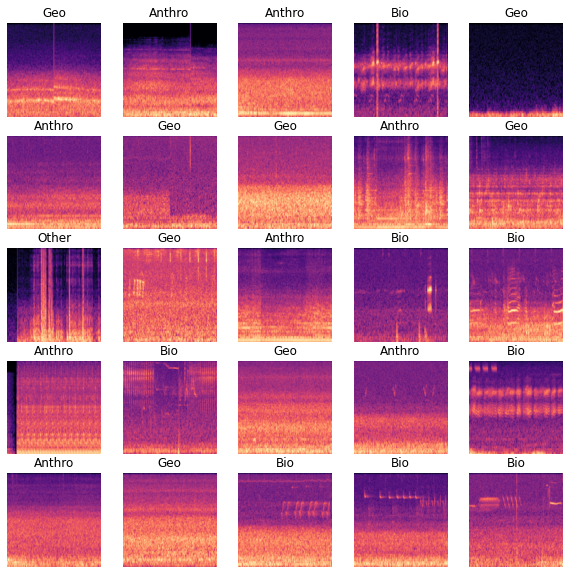

In [27]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [28]:
# NOW WE HAVE:
print(validation_ds)
print(train_ds)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.bool)>


## MODEL TRAINING

In [29]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [30]:
n_classes = len(CLASS_NAMES)
n_classes

4

In [31]:
# Remove FC and Global pooling layers
base_model_output = new_model.layers[-3]#.output
print(base_model_output)
feature_batch = base_model_output(image_batch)

base_model_output.trainable = False

# Add pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Add FC/ Dense layers
n_classes = len(CLASS_NAMES) # based on the no. of classes
prediction_layer = tf.keras.layers.Dense(n_classes, activation = None)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# build a new 'model'
model = tf.keras.Sequential([
  base_model_output,
  global_average_layer,  
  prediction_layer
])

(64, 1792)
(64, 4)


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Functi (None, 7, 7, 1792)        4363712   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 7172      
Total params: 4,370,884
Trainable params: 7,172
Non-trainable params: 4,363,712
_________________________________________________________________


In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_output.layers))


Number of layers in the base model:  155


In [34]:
# Fine tune FC layers
base_learning_rate = 0.0001 #the initial learning rate. This will be reduced by a factor of 10 in the Finetuning stage

model.compile(#optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate),
              #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),         #Whether to interpret y_pred as a tensor of logit values. By default, we assume that y_pred contains probabilities (i.e., values in [0, 1]). **Note - Using from_logits=True may be more numerically stable.
              metrics=tf.keras.metrics.CategoricalAccuracy(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))         #Whether to interpret y_pred as a tensor of logit values. By default, we assume that y_pred contains probabilities (i.e., values in [0, 1]). **Note - Using from_logits=True may be more numerically stable.            
                #metrics=['accuracy'])
        

In [35]:
base_learning_rate

0.0001

In [36]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Functi (None, 7, 7, 1792)        4363712   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 7172      
Total params: 4,370,884
Trainable params: 7,172
Non-trainable params: 4,363,712
_________________________________________________________________


In [37]:
len(model.trainable_variables)


2

In [38]:
# NOW USE THE validation_ds and train_ds THAT WE BUILT BEFORE
loss0,accuracy0 = model.evaluate(validation_ds, steps= val_image_count // BATCH_SIZE)

10/10 [==============================] - 17s 2s/step - loss: 0.8023 - categorical_accuracy: 0.2910

In [39]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.28


In [40]:
initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds, 
                    steps_per_epoch = np.ceil(image_count/BATCH_SIZE))

Epoch 1/10
111/111 [==============================] - 195s 2s/step - loss: 0.5243 - categorical_accuracy: 0.4897 - val_loss: 0.4778 - val_categorical_accuracy: 0.5492

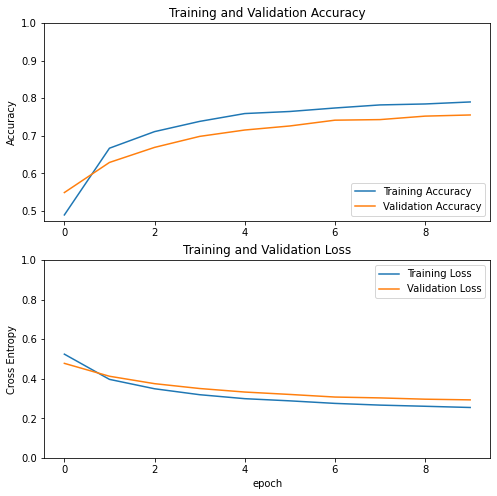

In [41]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
base_model_output.trainable = True


In [43]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_output.layers))


Number of layers in the base model:  155


In [44]:
# Train CNN features here
# Fine-tune from this layer onwards

#originally fine_tune_at = 50
fine_tune_at = 45

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_output.layers[:fine_tune_at]:
    layer.trainable = False

In [45]:
second_tr_lr = base_learning_rate/15

In [46]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=second_tr_lr), # reduce lr by a factor of 10! LR is 0.00001 here then
              metrics=tf.keras.metrics.CategoricalAccuracy(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))         #Whether to interpret y_pred as a tensor of logit values. By default, we assume that y_pred contains probabilities (i.e., values in [0, 1]). **Note - Using from_logits=True may be more numerically stable.            
 

In [47]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Functi (None, 7, 7, 1792)        4363712   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 7172      
Total params: 4,370,884
Trainable params: 4,245,540
Non-trainable params: 125,344
_________________________________________________________________


In [48]:
len(model.trainable_variables)


113

In [49]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

In [50]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,  # save the best model based on what's being monitored
                                                 monitor='val_categorical_accuracy',
                                                 verbose=1)

In [51]:
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data = validation_ds,
                         steps_per_epoch = np.ceil(image_count/BATCH_SIZE),
                         callbacks=[cp_callback]) # added this callback for checkpointing
model.save('xc_model_2021_.pb')


Epoch 10/20
111/111 [==============================] - 470s 4s/step - loss: 0.3049 - categorical_accuracy: 0.7363 - val_loss: 0.2620 - val_categorical_accuracy: 0.7754

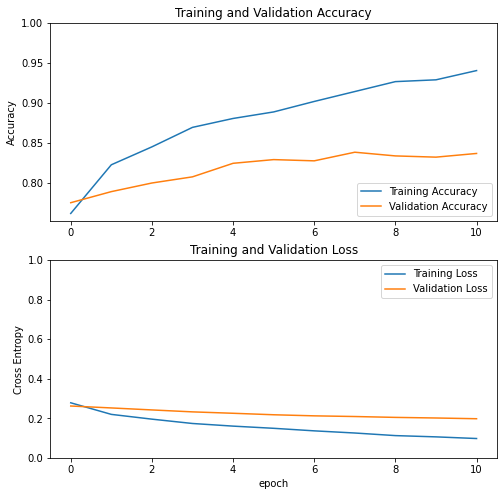

In [52]:

acc = history_fine.history['categorical_accuracy']
val_acc = history_fine.history['val_categorical_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### DATA VIZ

In [53]:
from sklearn.metrics import confusion_matrix
history_fine.show_conf_matrix()

AttributeError: 'History' object has no attribute 'show_conf_matrix'

In [ ]:
#show_conf_matrix(model)